<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/Image_Simulation_JWST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b> How to use PISTA for image simulation</b></h1>

# **Initialize**

Do not edit this section

In [31]:
#!pip install insist-pista --quiet
# For Development version. Uncomment and run the code below instead
!pip install git+https://github.com/Jack3690/INSIST --quiet

  Preparing metadata (setup.py) ... done


In [1]:
import pista as pt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pandas as pd
import os

import astropy.units as u
from astropy.table import Table, vstack
from astropy.visualization import make_lupton_rgb

import seaborn as sb

In [2]:
data_path = pt.data_dir

# **Python Image Simulation and Testing Application (PISTA)**

PISTA package allows user to simulate resolved stellar population using source catalog and detector characteristics. This notebook contains few examples on how to use PISTA

## **Step 1**
Upload a dataframe with columns 'ra', 'dec', 'mag'.

In [3]:
# Example using FITS table
tab = Table.read(f'{data_path}/sample.fits')  # FITS Table
df  = tab.to_pandas()             # PISTA requires pandas DataFrame
df

,ra,dec,mag,s_F275W
0,11.058884,41.343124,19.441000,110.800003
1,11.060650,41.343782,24.539000,5.200000
2,11.061190,41.343785,21.142000,46.599998
3,11.061413,41.345837,24.612000,6.000000
4,11.061744,41.343196,22.931000,17.700001
...,...,...,...,...
534,11.071035,41.358390,24.594000,5.700000
535,11.071245,41.358205,24.337999,6.900000
536,11.071255,41.358967,20.018000,84.300003
537,11.071642,41.359526,24.660999,5.400000


In [7]:
# Run these cells to upload files otherwise ignore
from google.colab import files

uploaded = files.upload()

In [ ]:
ls # Shows the files in the current working directory

## **Step 2**

Create a dictionary object with telescope parameters.


Dictionary structure

```
tel_params : dict,
 |                   {'aperture'       : float,  cm
 |                    'pixel_scale'    : float,  arcsecs/pixels
 |                    'psf_file'       : fits,npy
 |                    'response_funcs' : list, [filename.dat, n, max]
 |
 |                                             where
 |                                             n is number of times
 |                                             a given profile is repeated.
 |                                             For example if there are 5
 |                                             mirrors with sample coating
 |                                             profile, n = 5.
 |
 |                                             max is the upper limit of a
 |                                             response function. For example,
 |                                             if filter profiles are in
 |                                             percentage, max = 100.
 |
 |                    'coeffs'         : float, filter coefficients if not
 |                                            response_funcs
 |                    }
```

aperture : aperture of the primary mirror in cms <br>

pixel_scale : pixel scale of the detector in arcseconds/pixels<br>

sim_file    : path to the file containing point spread function data in the form of a 2D array. User can use both npy or FITS data. <br>

response_funcs : Dictionary containing paths to filter, dichroic, coating efficiency, quantum efficieny etc. profiles.<br>

Format for dictionary is [\<path>, \<multiplicity factor>, \<maximum value>]<br>


```
response_funcs = [
                   '..\path\coating.dat,1,100',
                   '..\path\dichroic.dat,2,1'
                 ]

```

coeffs : response coefficient. If user doesn't wanna use filter and response function profiles. They can directly enter the total multiplicate factor that needs to go into the effective area. Such that coeff = c1*c2*c3*..

Where c1,c2,c3 are response function coefficients

In the example below we will use INSIST parameters which is included in the PISTA package data

In [9]:
tel_params ={
            'aperture'       : 650,
            'pixel_scale'    : 0.031,
            'oversamp'       : 4,
            'psf_file'       : f'PSF_NIRCam_in_flight_opd_filter_F115W.fits',
            'response_funcs' :  [ 'JWST_NIRCam.F115W.dat,1,1',
                                ],
            'coeff'          : 25/(np.pi*(6.5/2)**2)

            }

## **Step 3**

Initialize PISTA Analyzer object

n_x : Number of pixels along RA direction. <br>
n_y : Number of pixels along Dec direction <br>
exp_time : Exposure time in seconds

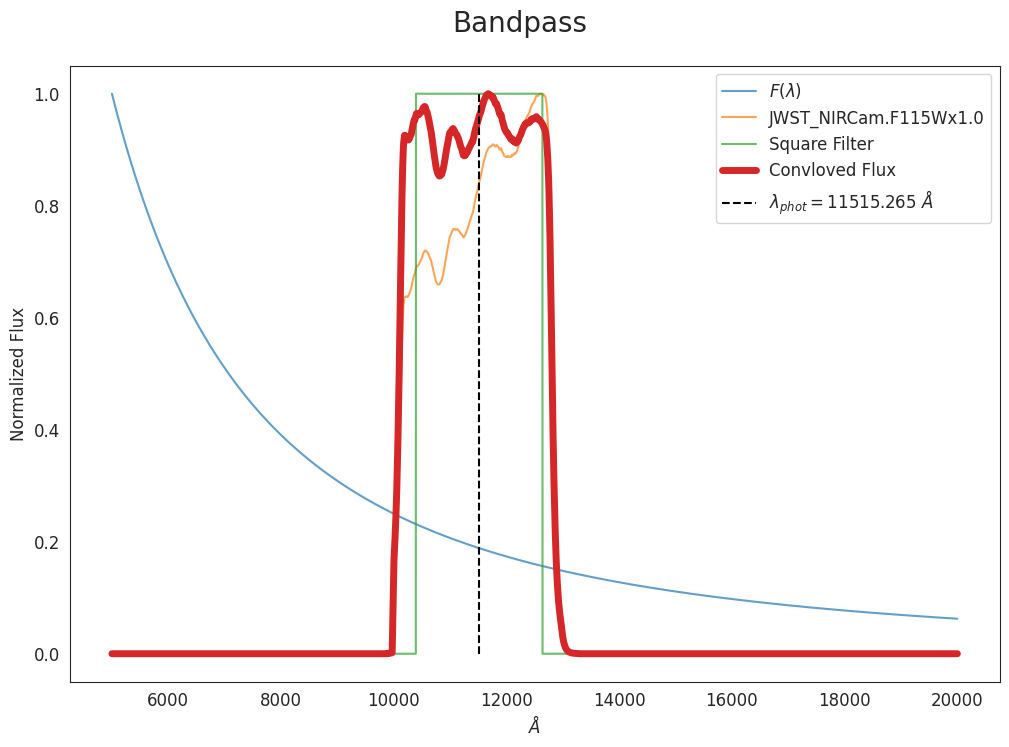

In [10]:
sim = pt.Imager(df = df,tel_params = tel_params, n_x = 2048, n_y = 2048,
                  exp_time = 1000, plot_bandpass=True)

(<Figure size 1200x1000 with 2 Axes>,
 <Axes: title={'center': 'Requested Center :  RA : 11.069 degrees, Dec : 41.352 degrees | 539 sources\n          Fov(RA) : 0.0176 (deg) | Fov(Dec) : 0.0176 (deg)'}, xlabel='RA (Degrees)', ylabel='Dec (Degrees)'>)

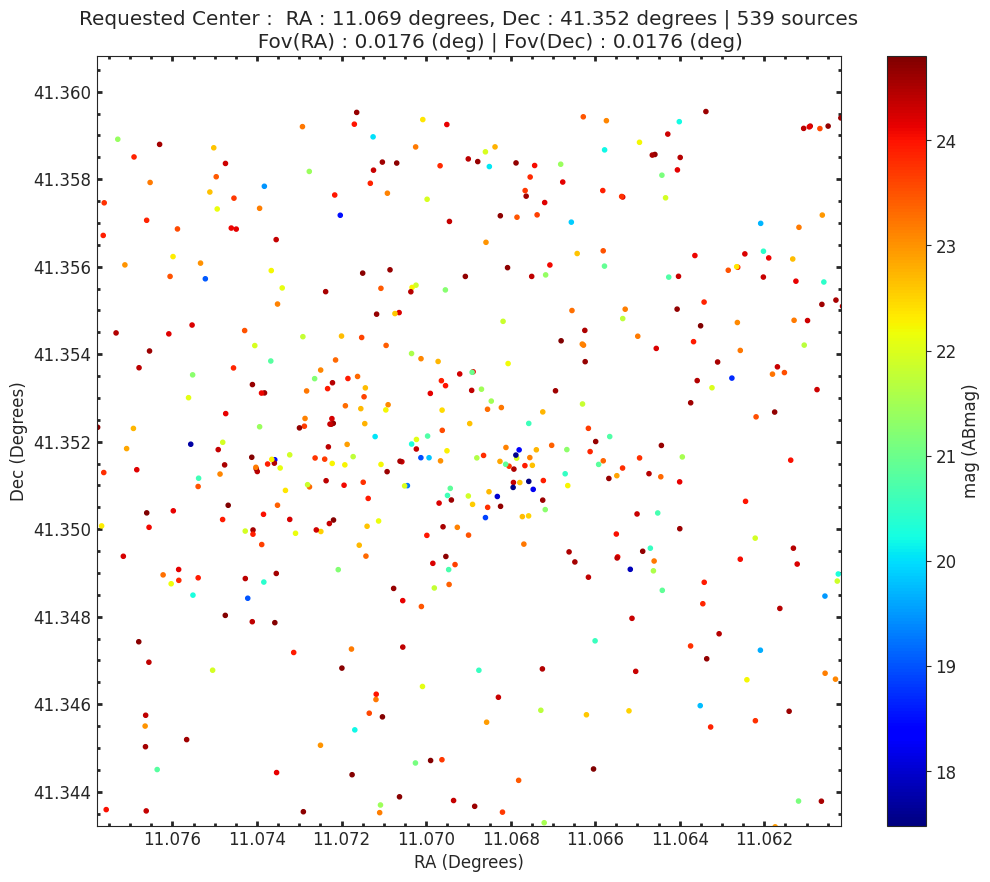

In [11]:
sim.show_field(figsize=(12, 10)) # Displays the RA-Dec scatter of sources withing the Field of View

## **Step 4**

Create dictionary object with Detector parameters



```
det_params: dict, optional
        Dictionary contianing detector parameters. The default is None.
                   {     'shot_noise' :  str,
                         'M_sky'      :  float,    Sky magnitude
                         'qe_response':  list,     QE Response Function
                         'qe_mean'    :  float
                         'qe_sigma'   :  float,    Pixel to pixel fluctuation
                         'bias'       :  float,    electrons
                         'G1'         :  float,    ADU/e
                         'bit_res'    :  int,
                         'RN'         :  float,     elec/pix
                         'PRNU_frac'  :  float,     PRNU sigma
                         'T'          :  float,     K
                         'DFM'        :  float,     pA
                         'pixel_area' :  float,     cm2
                         'DCNU'       :  float,     DNCU sigma
                         'DNFP        :  float,     Fixed patter value
                         'NF'         :  float,     electrons
                         'FWC'        :  float,     electrons
                         'C_ray_r'    :  float      hits/second
                     }
```


shot_noise : Distribuition to be used for shot_noise, 'Gaussian' or 'Possonian' <br>

M_sky : sky magnitude in $ABmag/arcsecond^2$. If filter profiles are not used.<br>

qe_sigma : standard deviation of quantum efficiency across pixel on the detector. <br>

bias : detector offset in electrons<br>

G1   : Detector gain<br>

bit_res : bit resolution of the detector<br>

RN      : Read noise of the detector in electrons<br>

PRNU_frac: Photon Responce non uniformity fraction<br>

T        : Temperature of the detector in Kelvin <br>

DFM      : Dark Current figure of meric in unit $pA/cm^2$ <br>

pixel_area : area of pixel in cm^2 <br>

DCNU   : Dark Current Non Uniformity <br>

DNFP   : Dark Current Fixed Pattern <br>

NF   : Noise floor in electrons<br>

C_ray_r' cosmic ray hits rate $hits/second/arcsecond^2$

In [41]:
det_params = {    'shot_noise' : 'Gaussian',
                  'G1'         : 1,
                  'PRNU_frac'  : 0.25/100,
                  'qe_mean'    : 0.8,
                  'qe_sigma'   : 0.01,
                  'FWC'        : 131072,
                  'bit_res'    : 16,
                  #'qe_response': [f'{data_path}/INSIST/UV/QE.dat,1,100'],
                  'RN'         :  16,
                  'T'          :  40,
                  'DFM'        : 2.5e-5,
                  'DCNU'       :  0.1/100
             }

In [43]:
sim.gain

2.0

## **Step 5**

Run simulation by calling the sim object with required arguments

In [42]:
sim(det_params = det_params, photometry = 'Aper', detect_source = True)

  0%|          | 0/539 [00:00<?, ?it/s]

(<Figure size 1500x1000 with 2 Axes>,
 <WCSAxes: title={'center': 'Digital \nRequested center :  RA : 11.069 degrees, Dec : 41.352 degrees'}>)

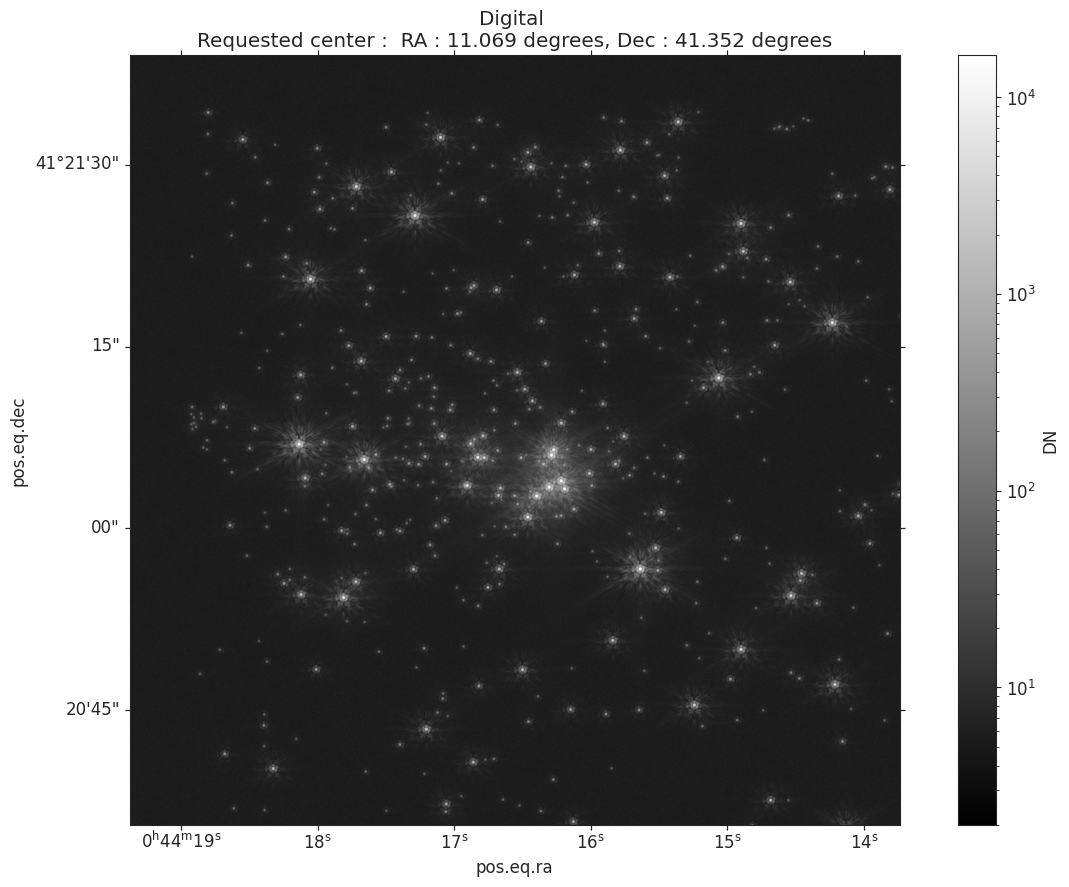

In [15]:
sim.show_image(cmap='gray') # Displays the final simulated digital image

In [ ]:
sim.show_image('DC') # Shows dark current frame

In [ ]:
sim.show_hist() # Shows histogram of final image

In [ ]:
sim.show_hist('DC') #Shows histogram of dark current frame

In [ ]:
sim.phot_table # Displays table with aperture photometry of the image

**Comparing input magnitude vs output magnitude**

In [ ]:
x = sim.phot_table['mag_in']
y = sim.phot_table['mag_out']-sim.phot_table['mag_in']

plt.figure(figsize = (10,5))
plt.scatter(x, y)
plt.xlabel('Input (Mag)')
plt.ylabel('Output - Input (Mag)')

In [ ]:
x = sim.phot_table['mag_in']
y = sim.phot_table['mag_out']
y_err = abs(sim.phot_table['mag_err'])
plt.errorbar(x,y,yerr= y_err,fmt='o', color = 'black', markersize=4, capsize=5)
plt.plot([16,30],[16,30],'--', color = 'red')
plt.xlim(17,30)
plt.ylim(17,30)
plt.xlabel('Input (mag)')
plt.ylabel('Output (mag)')

**Downloading output image as FITS**

In [ ]:
sim.writeto('sample_sim.fits')

In [ ]:
from google.colab import files

files.download('sample_sim.fits')

## **Explorative Analysis using the Simulator**

In this section we use PISTA to generate few standard plots and perform some analysis

### **Photon Response Curves**

In [ ]:
fig, ax = plt.subplots(1,1, figsize= (10,10))

tel_params = {'sim_file': f'{data_path}/PSF/INSIST/on_axis_hcipy.npy',
              'pixel_scale'   : 0.1,
              'response_funcs': [f'{data_path}/INSIST/UV/Coating.dat,5,100',
                                 f'{data_path}/INSIST/UV/Dichroic.dat,2,100',
                                 f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                 ]}


det_params = {'shot_noise': 'Gaussian',
                      'M_sky'      :  27,
                      'qe_response': [f'{data_path}/INSIST/UV/QE.dat,1,100'],
                      'qe_sigma'   :  0.01,       # Pixel to pixel fluctuation
                      'bias'       :  35,         # electrons
                      'G1'         :  1,
                      'bit_res'    :  14,
                      'RN'         :  5,          # elec/pix
                      'PRNU_frac'  :  0.25/100,   # PRNU sigma
                      'T'          :  218,        # K
                      'DFM'        :  1.424e-2,   # 14.24 pA
                      'pixel_area' :  1e-6,       #
                      'DCNU'       :  0.1/100,    #
                      'DNFP'       :  10.,
                      'NF'         :  0,          # electrons
                      'FWC'        :  1.4e5,      # electrons
                      'C_ray_r'    :  2/50        # hits/second
                   }

sim =  pt.Imager(df = df, tel_params = tel_params, exp_time = 600,
             n_x  = 800, n_y = 800)

sim.QE   = False
sim.sky  = False
sim.PRNU = False
sim.DC   = False

sim(det_params = det_params)


# Source Photons
x = (sim.source_photoelec).ravel()
y = x/np.sqrt(sim.source_photoelec).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.scatter(x,y,s=1,marker = '.', color ='black')

sim = pt.Imager(df = df, tel_params = tel_params, exp_time = 600,
                n_x  = 800, n_y = 800)


sim.QE   = True
sim.sky  = False
sim.PRNU = False
sim.DC   = False

sim(det_params = det_params)

# Source Photoelectrons
x = (sim.source_photoelec).ravel()
y = x/np.sqrt(sim.source_photoelec).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.scatter(x,y,s=1,marker = '.', color ='black')

sim = pt.Imager(df=df, tel_params=tel_params, exp_time=600,
                n_x=800, n_y=800)


sim.QE   = True
sim.sky  = False
sim.PRNU = True
sim.DC   = False

sim(det_params = det_params)

# PRNU
x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.PRNU_array**2).ravel()
x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)

ax.scatter(x,y,s=1,marker = '.', color ='blue')

sim = pt.Imager(df=df, tel_params=tel_params, exp_time=600,
                n_x=800, n_y=800)

sim.QE   = True
sim.sky  = False
sim.PRNU = True
sim.DC   = True
sim.DCNU = False
sim.DNFP = False

sim(det_params = det_params)

# With DC

x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.PRNU_array**2 + sim.DC_array).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.scatter(x,y,s=1,marker = '.', color ='green')

sim = pt.Imager(df=df, tel_params=tel_params, exp_time=600,
                n_x=800, n_y=800)

sim.QE   = True
sim.sky  = False
sim.PRNU = True
sim.DC   = True
sim.DCNU = True
sim.DNFP = False
sim(det_params = det_params)

# With DCNU
x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.PRNU_array**2 + sim.DC_array + sim.DCNU_array**2).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.scatter(x,y,s=1,marker = '.', color ='purple')

sim = pt.Imager(df=df, tel_params=tel_params, exp_time=600,
                n_x=800, n_y=800)

sim.QE   = True
sim.sky  = False
sim.PRNU = True
sim.DC   = True
sim.DCNU = True
sim.DNFP = True
sim(det_params = det_params)

# With DNFP
x = (sim.photoelec_array-sim.DC_array).ravel()
y = x/np.sqrt(sim.photoelec_array + sim.PRNU_array**2 + sim.DC_array + sim.DCNU_array**2 + sim.DNFP_array).ravel()

x = np.where(x==0,np.nan,x)
y = np.where(y==0,np.nan,y)
ax.scatter(x,y,s=1,marker = '.', color ='red')


ax.set_xlabel('Counts')
ax.set_ylabel('SNR')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-4,1e7)
ax.set_ylim(1e-4,1e4)
ax.xaxis.set_major_locator(LogLocator(numticks=15))
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10)))

plt.grid(True, which="both",axis = 'both', ls="-", color='0.65')
plt.legend(['Photon','PhotonxQE', 'PhotonxPRNUxQE', 'PhotonxPRNUxQE + DC','PhotonxPRNUxQE + DCxDCNU','PhotonxPRNUxQE + DCxDCNU + DNFP']);

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.DNFP_array[:,500])
ax[0].set_title('X_cut')
ax[0].set_xlabel('X')
ax[0].set_ylabel('DN')
ax[1].plot(sim.DNFP_array[50,:])
ax[1].set_title('Y_cut')
ax[1].set_xlabel('Y')

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.DNFP_array[:,392])
ax[0].plot(sim.DNFP_array.mean(axis = 0))
ax[0].plot(sim.DNFP_array.min(axis = 0))
ax[0].plot(sim.DNFP_array.max(axis = 0))
ax[0].set_title('Along Row')
ax[0].set_xlabel('X')
ax[0].set_ylabel('DN')
ax[1].plot(sim.DNFP_array[392,:])
ax[1].plot(sim.DNFP_array.mean(axis = 1))
ax[1].plot(sim.DNFP_array.min(axis = 1))
ax[1].plot(sim.DNFP_array.max(axis = 1))
ax[1].set_title('Along Column')
ax[1].set_xlabel('Y')
fig.suptitle('DNFP')
plt.legend(['Signal', 'Mean','Min','Max'])

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,8), sharey = True)
ax[0].plot(sim.PRNU_array[:,392])
ax[0].plot(sim.PRNU_array.mean(axis = 0))
ax[0].plot(sim.PRNU_array.min(axis = 0))
ax[0].plot(sim.PRNU_array.max(axis = 0))
ax[0].set_title('Along Row')
ax[0].set_xlabel('X')
ax[0].set_ylabel('PRNU')
ax[1].plot(sim.PRNU_array[392,:])
ax[1].plot(sim.PRNU_array.mean(axis = 1))
ax[1].plot(sim.PRNU_array.min(axis = 1))
ax[1].plot(sim.PRNU_array.max(axis = 1))
ax[1].set_title('Along Column')
ax[1].set_xlabel('Y')
fig.suptitle('PRNU')
plt.legend(['Signal', 'Mean','Min','Max'])

### **Off axis Vs On Axis**

In [ ]:
tel_params_off ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/off_axis_poppy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                 f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                ],
            }

tel_params_on ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/on_axis_poppy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Coating.dat,6,100',   # 5 mirrors
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                ],
            'coeffs'          : 0.17
            }

In [ ]:
y,x = 2*np.mgrid[0:10,0:10]/3600

ra  = 10 + x.ravel()
dec = 10 + y.ravel()
mag = np.linspace(18, 30, 100)
df  = pd.DataFrame(zip(ra,dec,mag), columns = ['ra','dec','mag'])

In [ ]:
sim_off = pt.Imager(df = df,tel_params = tel_params_off, n_x = 200, n_y = 200,
                   exp_time = 2400)
sim_on = pt.Imager(df = df,tel_params = tel_params_on,   n_x = 200, n_y = 200,
                   exp_time = 2400)

In [ ]:
sim_off.W_eff, sim_off.lambda_phot

In [ ]:
sim_on.W_eff, sim_on.lambda_phot

In [ ]:
sim_off.zero_flux/sim_on.zero_flux

In [ ]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    :  1,
              'G1'         :  1,
              'bias'       :  10,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
sim_off(det_params=det_params, detect_sources=False)
sim_on(det_params=det_params, detect_sources=False)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (7,7))

data = sim_off.phot_table.to_pandas()
data = data.dropna()
x = data['mag_in']
y = data['SNR']

t = np.where(y<5)[0][0]
ax.scatter(x,y )

ax.plot([20,30],[5,5], color = 'black')
ax.set_title('Off Axis Vs On Axis | Exp time : 2400 Seconds ')

ax.annotate('{0:.2f}'.format(x[t]), (x[t],5), xytext = (x[t]+1,5+10),arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color = 'black'))

data = sim_on.phot_table.to_pandas()
data = data.dropna()
x = data['mag_in']
y = data['SNR']

t = np.where(y<5)[0][0]
ax.scatter(x,y)
ax.set_xlabel('Input Magnitude')
ax.set_ylabel('SNR')
ax.legend(['SNR = 5', 'Off axis', 'On axis'])
ax.annotate('{0:.2f}'.format(x[t]), (x[t],5), xytext = (x[t]+1,5+15),arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color = 'black'))

plt.subplots_adjust(wspace = 0.01)

### **INSIST vs UVIT vs GALEX**

In [ ]:
!git clone https://github.com/Jack3690/INSIST

In [ ]:
data_git = '/content/INSIST/data'

In [ ]:
# Example using FITS table
tab = Table.read(f'{data_path}/sample.fits')  # FITS Table
df  = tab.to_pandas()             # PISTA requires pandas DataFrame

In [ ]:
tel_params_insist = {
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/on_axis_hcipy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                  f'{data_path}/INSIST/UV/QE.dat,1,100'
                                ],
            }
tel_params_uvit = {
            'aperture'       : 1,
            'pixel_scale'    : 3.33/8,
            'psf_file'       : f'{data_git}/UVIT/PSF/on_axis_hcipy.npy',
            'response_funcs' :  [ f'{data_git}/UVIT/filters/Astrosat_UVIT.F148W.dat,1,1'
                                ],
            'coeffs'         : 1/(np.pi*0.5**2)
            }

tel_params_galex = {
            'aperture'       : 1,
            'pixel_scale'    : 1.5,
            'psf_file'       : f'{data_git}/GALEX/PSF/PSFnuv_faint.fits',
            'response_funcs' :  [ f'{data_git}/GALEX/filters/GALEX_GALEX.NUV.dat,1,1'
                                ],
            'coeffs'         : 1/(np.pi*0.5**2)
                  }

In [ ]:
det_params_insist = {'shot_noise': 'Poisson',
                    'bias': 35,
                    'G1': 1,
                    'bit_res': 14,
                    'RN': 5,
                    'PRNU_frac': 0.0025,
                    'T': 218,
                    'DFM': 0.01424,
                    'pixel_area': 1e-06,
                    'DN': 0.001,
                    'NF': 12,
                    'FWC': 140000.0,
                    'C_ray_r': 0.04}

det_params_uvit  = {'shot_noise': 'Poisson',
                    'bias': 100,
                    'G1': 1,
                    'bit_res': 14,
                    'RN': 5,
                    'PRNU_frac': 0.0025,
                    'T': 293,
                    'DFM': 0.004624,
                    'pixel_area': (25/8)*1e-6,
                    'DN': 0.001,
                    'NF': 0,
                    'FWC': 150000.0}

det_params_galex = {'shot_noise': 'Poisson',
                    'bias': 35,
                    'G1': 1,
                    'bit_res': 14,
                    'RN': 5,
                    'PRNU_frac': 0.0025,
                    'T': 293,
                    'DFM': 0.01424,
                    'pixel_area': (25/8)*1e-06,
                    'DN': 0.001,
                    'NF': 0,
                    'FWC': 140000.0}

In [ ]:
sim_galex  = pt.Imager(df = df,coords = (11.06875, 41.3513),
                        tel_params = tel_params_galex, n_x = 27, n_y = 27,
                        exp_time = 2000)

sim_uvit   = pt.Imager(df = df, coords = (11.06875, 41.3513),
                      tel_params = tel_params_uvit, n_x = 96, n_y = 96,
                      exp_time = 2000)

sim_insist = pt.Imager(df = df, coords = (11.06875, 41.3513),
                      tel_params = tel_params_insist, n_x = 400, n_y = 400,
                      exp_time = 2000)

In [ ]:
sim_galex.DC = False
sim_galex(det_params = det_params_galex)
sim_uvit.DC = False
sim_uvit(det_params = det_params_uvit)

sim_insist(det_params = det_params_insist)

In [ ]:
fig,ax = sim_galex.show_image()
fig.suptitle('GALEX')

In [ ]:
fig, ax = sim_uvit.show_image()
fig.suptitle('UVIT')

In [ ]:
fig, ax = sim_insist.show_image()
fig.suptitle('INSIST')

In [ ]:
sim_galex.writecomp('galex.fits'), sim_uvit.writecomp('uvit.fits'), sim_insist.writecomp('insist.fits')

In [ ]:
!zip comp galex.fits uvit.fits insist.fits

# **ArtPop**

Combining ArtPop and PISTA

In [ ]:
!pip install artpop --quiet

In [ ]:
import artpop as art

In [ ]:
art.phot_system_list

In [ ]:
rng = np.random.RandomState(369)

In [ ]:
src = art.MISTSersicSSP(
    log_age = 6,        # log of age in years
    feh = -2.5,           # metallicity [Fe/H]
    r_eff = 250 * u.pc,   # effective radius
    n = 0.8,              # Sersic index
    theta = 135 * u.deg,  # position angle
    ellip = 0.3,          # ellipticity
    num_stars = 1e6,      # number of stars
    phot_system = 'GALEX', # photometric system
    distance = 5 * u.Mpc, # distance to system
    xy_dim = 801,         # image dimension
    pixel_scale = 0.1,    # pixel scale in arcsec / pixel
    random_state = rng,   # random state for reproducibility
)

In [ ]:
imager = art.ArtImager(
    phot_system  = 'GALEX', # photometric system
    diameter     =  1*u.m, # effective aperture diameter
    read_noise   = 3,       # read noise in electrons
    random_state = rng    # random state for reproducibility
)

In [ ]:
psf = art.moffat_psf(fwhm=0.2*u.arcsec)

# observe in gri (assuming the same seeing in all bands)
obs_g = imager.observe(
    source = src,         # source object
    bandpass = 'GALEX_NUV',  # bandpass of observation
    exptime = 10 * u.min, # exposure time
    sky_sb = 27,          # sky surface brightness
    psf = psf             # point spread function
)
obs_r = imager.observe(src, 'GALEX_NUV', 10 * u.min, sky_sb=27, psf=psf)
obs_i = imager.observe(src, 'GALEX_FUV', 30 * u.min, sky_sb=27, psf=psf)

rgb = make_lupton_rgb(obs_i.image, obs_r.image, obs_g.image, stretch=0.4)

art.show_image(rgb);

In [ ]:
df = pd.DataFrame(zip(src.x, src.y), columns =['x', 'y'])

In [ ]:
df['mag'] = src.mags['GALEX_NUV']

In [ ]:
tel_params ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/on_axis_hcipy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                ],
            }

In [ ]:
sim = pt.Imager(df = df,tel_params = tel_params, n_x = 801, n_y = 801,
                   exp_time = 1800)

In [ ]:
sim.show_field()

In [ ]:
det_params = {    'shot_noise' :  'Gaussian',
                  'G1'         :  1,
                  'PRNU_frac'  :  0.25/100,
                  'RN'         :  5,
                  'T'          :  218,
                  'DN'         :  0.1/100
                     }

In [ ]:
sim(det_params = det_params, photometry = None)

In [ ]:
sim.show_image(cmap = 'gray') # Displays the final simulated digital image